<a href="https://colab.research.google.com/github/romanzes637/tensor/blob/master/clust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [47]:
import numpy as np

paths = ['/gdrive/My Drive/Colab Notebooks/tube10El/{}/devStr'.format(x) for x in range(1, 35)]
with open(paths[20], 'r') as f:
  lines = f.readlines()
#   for i in range(18):
#     next(f)
  X = np.array([[float(y) for y in x.strip()[1:-1].split()] for x in lines[18:-5]])
print(len(X), X[0], X[-1])

16000 [-2.22738e+07  1.05822e+08  1.72080e-01 -1.04392e+07  1.46006e+00
  3.27130e+07] [-1.40360e+07  3.08915e+07  6.98932e-02 -2.03111e+07  1.04710e-02
  3.43470e+07]


[-2.22738e+07  1.05822e+08  1.72080e-01 -1.04392e+07  1.46006e+00
  3.27130e+07]
[-2.10483642e-01  1.00000000e+00  1.62612689e-09 -9.86486742e-02
  1.37973200e-08  3.09132317e-01]
Isomap: 27 sec
MDS: 1e+03 sec


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralEmbedding: 1.1 sec
t-SNE: 97 sec


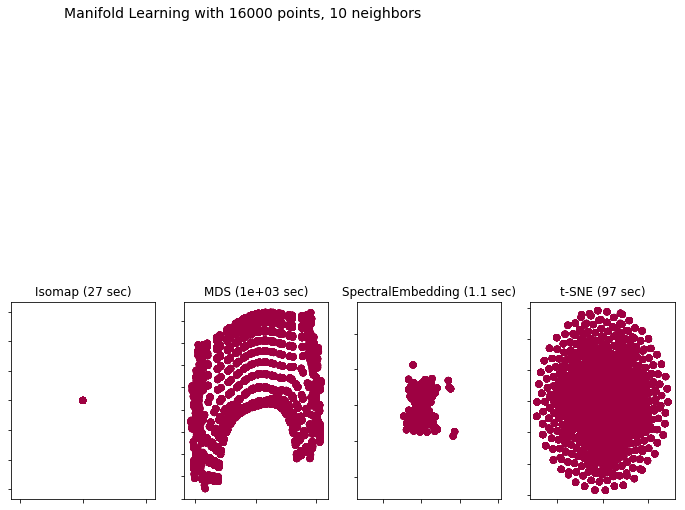

In [48]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets, preprocessing

# Next line to silence pyflakes. This import is needed.
Axes3D  

np.random.seed(0)
# X = X[:3000]
n_points = len(X)
# n_points = 100
# X = np.random.choice([-2., -1., 0., 1., 2.], (n_points, 6))
# X, color = datasets.samples_generator.make_s_curve(n_points, noise=0.2, random_state=0)
# print(X)
# print(color)
n_groups = 1
print(X[0])
X = preprocessing.normalize(X, norm='max')
print(X[0])
# X[(X > -1e-6) & (X < 1e-6)] = 0.
# X[X >= 1e-6] = 1.
# X[X <= -1e-6] = -1.
# print(X[0])
groups = np.linspace(0, 1, n_groups)
color = np.random.choice(groups, (n_points))
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (n_points, n_neighbors), fontsize=14)

# ax = fig.add_subplot(251, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

# for i, method in enumerate(methods):
#     t0 = time()
#     Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
#                                         eigen_solver='auto',
#                                         method=method).fit_transform(X)
#     t1 = time()
#     print("%s: %.2g sec" % (methods[i], t1 - t0))

#     ax = fig.add_subplot(252 + i)
#     plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
#     plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     plt.axis('tight')


t0 = time()
Y1 = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y1[:, 0], Y1[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y2 = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y2[:, 0], Y2[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y3 = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y3[:, 0], Y3[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y4 = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y4[:, 0], Y4[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/optics_.py:795: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/birch.py:627: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


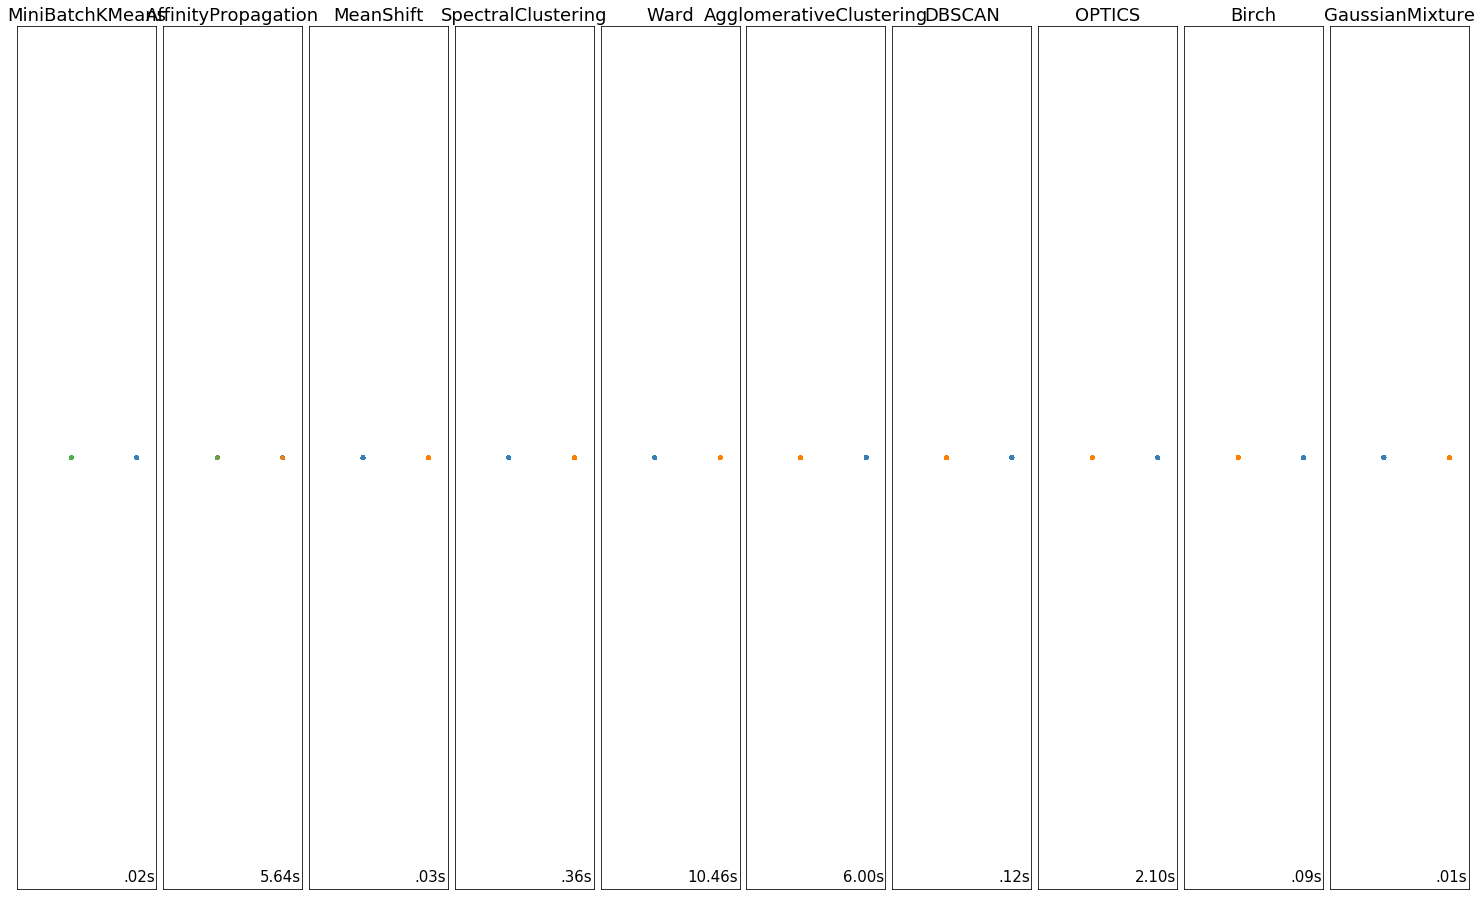

In [46]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

# datasets = [
#     (noisy_circles, {'damping': .77, 'preference': -240,
#                      'quantile': .2, 'n_clusters': 2,
#                      'min_samples': 20, 'xi': 0.25}),
#     (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
#     (varied, {'eps': .18, 'n_neighbors': 2,
#               'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
#     (aniso, {'eps': .15, 'n_neighbors': 2,
#              'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
#     (blobs, {}),
#     (no_structure, {})]
datasets = [
    ((Y4, color), {})
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()